In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '43-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 25,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 25,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [15]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [16]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [17]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000295 to 5.11e-06


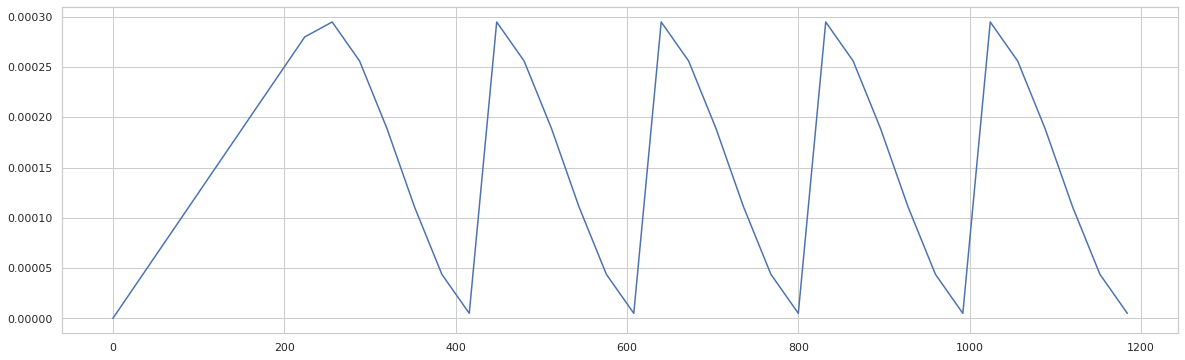

In [18]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch  = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch 
hold_max_steps = 0
warmup_steps = steps_per_epoch  * 5
num_cycles = 5

rng = [i for i in range(0, total_steps, 32)]
y = [cosine_with_hard_restarts_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                                    warmup_steps=warmup_steps, lr_start=lr_start, 
                                                    lr_max=lr_max, lr_min=lr_min, num_cycles=num_cycles) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [19]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [21]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: cosine_with_hard_restarts_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                    total_steps=total_steps, warmup_steps=warmup_steps, 
                                                                    lr_start=lr_start, lr_max=lr_max, lr_min=lr_min, 
                                                                    num_cycles=num_cycles)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            optimizer = tfa.optimizers.SWA(optimizer, start_averaging=int(steps_per_epoch * 5), average_period=int(steps_per_epoch * 4))
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
        
        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


48/48 - 29s - loss: 0.5828 - auc: 0.5251 - val_loss: 0.5514 - val_auc: 0.5037
Epoch 2/25
48/48 - 15s - loss: 0.2156 - auc: 0.6139 - val_loss: 0.1795 - val_auc: 0.6177
Epoch 3/25
48/48 - 15s - loss: 0.1689 - auc: 0.8273 - val_loss: 0.1717 - val_auc: 0.6694
Epoch 4/25
48/48 - 15s - loss: 0.1670 - auc: 0.8592 - val_loss: 0.1698 - val_auc: 0.7531
Epoch 5/25
48/48 - 15s - loss: 0.1648 - auc: 0.8727 - val_loss: 0.1676 - val_auc: 0.8350
Epoch 6/25
48/48 - 15s - loss: 0.1632 - auc: 0.8870 - val_loss: 0.1646 - val_auc: 0.8537
Epoch 7/25
48/48 - 14s - loss: 0.1607 - auc: 0.9073 - val_loss: 0.1650 - val_auc: 0.8639
Epoch 8/25
48/48 - 15s - loss: 0.1589 - auc: 0.9206 - val_loss: 0.1632 - val_auc: 0.8683
Epoch 9/25
48/48 - 15s - loss: 0.1564 - auc: 0.9340 - val_loss: 0.1625 - val_auc: 0.8717
Epoch 10/25
48/48 - 13s - loss: 0.1579 - auc: 0.9209 - val_loss: 0.1642 - val_auc: 0.8538
Epoch 11/25
48/48 - 13s - loss: 0.1566 - auc: 0.9260 - val_loss: 0.1643 - val_auc: 0.8646
Epoch 12/25
48/48 - 15s - loss

INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/25
52/52 - 30s - loss: 0.6090 - auc: 0.5569 - val_loss: 0.4812 - val_auc: 0.5537
Epoch 2/25
52/52 - 16s - loss: 0.1988 - auc: 0.6385 - val_loss: 0.1814 - val_auc: 0.5774
Epoch 3/25
52/52 - 14s - loss: 0.1690 - auc: 0.8333 - val_loss: 0.1888 - val_auc: 0.6495
Epoch 4/25
52/52 - 16s - loss: 0.1645 - auc: 0.8645 - val_loss: 0.1733 - val_auc: 0.7819
Epoch 5/25
52/52 - 16s - loss: 0.1656 - auc: 0.8671 - val_loss: 0.1678 - val_auc: 0.8254
Epoch 6/25
52/52 - 16s - loss: 0.1626 - auc: 0.8852 - val_loss: 0.1646 - val_auc: 0.8780
Epoch 7/25
52/52 - 16s - loss: 0.1599 - auc: 0.9058 - val_loss: 0.1628 - val_auc: 0.8882
Epoch 8/25
52/52 - 15s - loss: 0.1584 - auc: 0.9231 - val_loss: 0.1618 - val_auc: 0.8924
Epoch 9/25
52/52 - 14s - loss: 0.1584 - auc: 0.9098 - val_loss: 0.1653 - val_auc: 0.8697
Epoch 10/25
52/52 - 14s - loss: 0.1579 - auc: 0.9226 - val_loss: 0.1619 - val_auc: 0.8850
Epoch 11/25
52/52 - 16s - loss: 0.1548 - auc: 0.9338 - val_loss: 0.1606 - val_auc: 0.8822
Epoch 12/25
52/52 -

INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.235.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/25
52/52 - 31s - loss: 0.5526 - auc: 0.5403 - val_loss: 0.4282 - val_auc: 0.4830
Epoch 2/25
52/52 - 16s - loss: 0.1925 - auc: 0.6587 - val_loss: 0.1780 - val_auc: 0.5535
Epoch 3/25
52/52 - 16s - loss: 0.1671 - auc: 0.8401 - val_loss: 0.1736 - val_auc: 0.6378
Epoch 4/25
52/52 - 16s - loss: 0.1654 - auc: 0.8677 - val_loss: 0.1720 - val_auc: 0.7321
Epoch 5/25
52/52 - 16s - loss: 0.1638 - auc: 0.8727 - val_loss: 0.1693 - val_auc: 0.8237
Epoch 6/25
52/52 - 16s - loss: 0.1623 - auc: 0.8909 - val_loss: 0.1664 - val_auc: 0.8641
Epoch 7/25
52/52 - 14s - loss: 0.1611 - auc: 0.9021 - val_loss: 0.1676 - val_auc: 0.8918
Epoch 8/25
52/52 - 16s - loss: 0.1569 - auc: 0.9279 - val_loss: 0.1631 - val_auc: 0.8997
Epoch 9/25
52/52 - 14s - loss: 0.1583 - auc: 0.9163 - val_loss: 0.1632 - val_auc: 0.8837
Epoch 10/25
52/52 - 14s - loss: 0.1575 - auc: 0.9202 - val_loss: 0.1632 - val_auc: 0.8793
Epoch 11/25
52/52 - 16s - loss: 0.1547 - auc: 0.9272 - val_loss: 0.1619 - val_auc: 0.8945
Epoch 12/25
52/52 -

## Model loss graph

Fold: 1


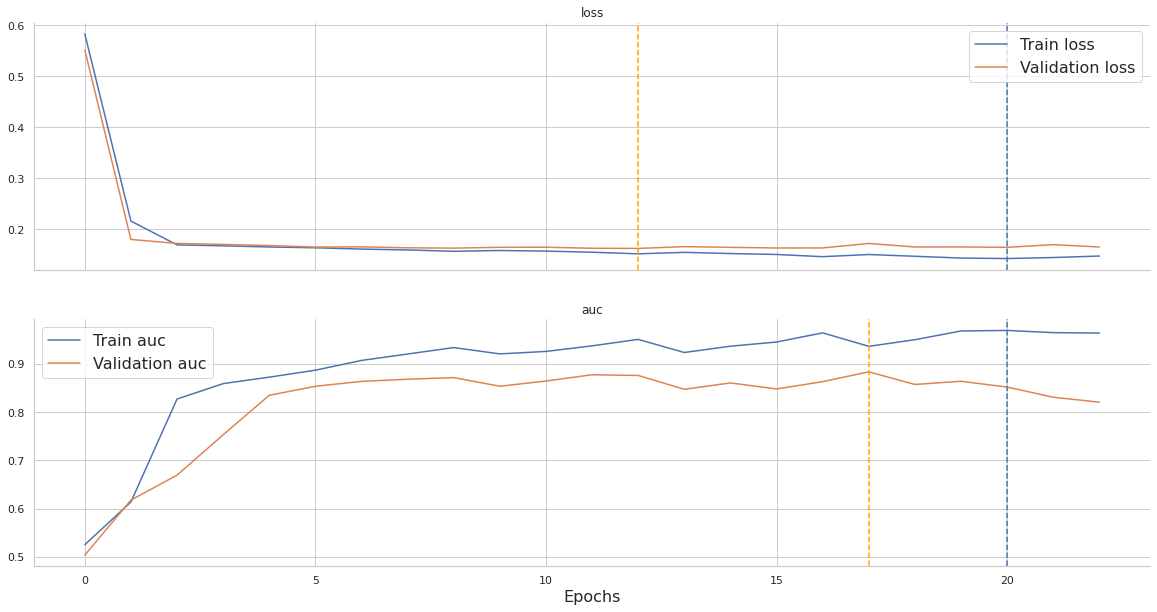

Fold: 2


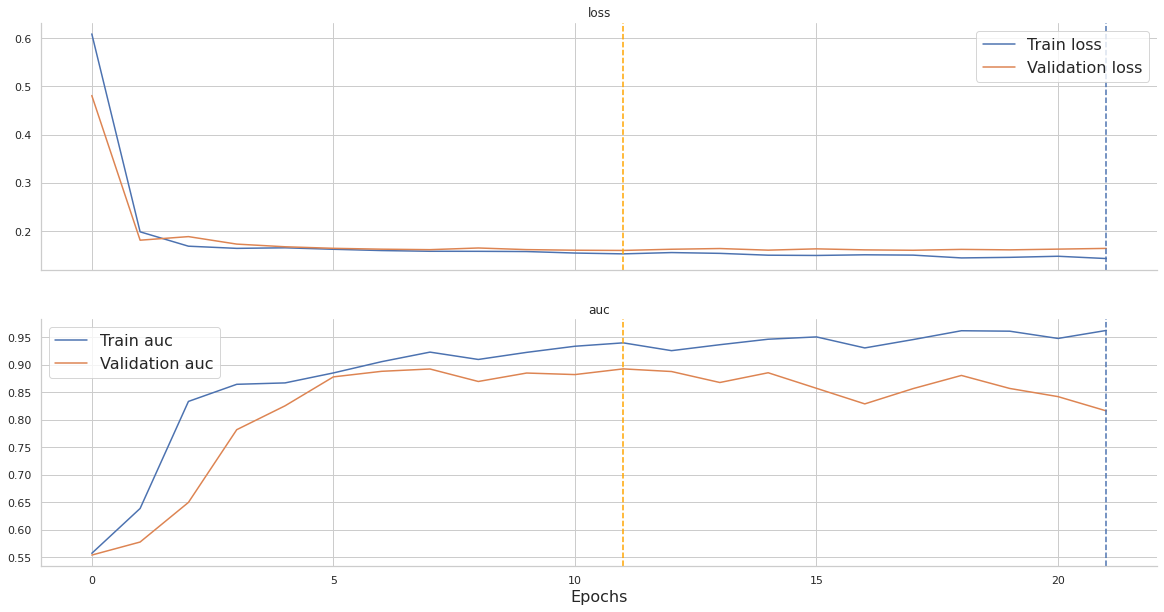

Fold: 3


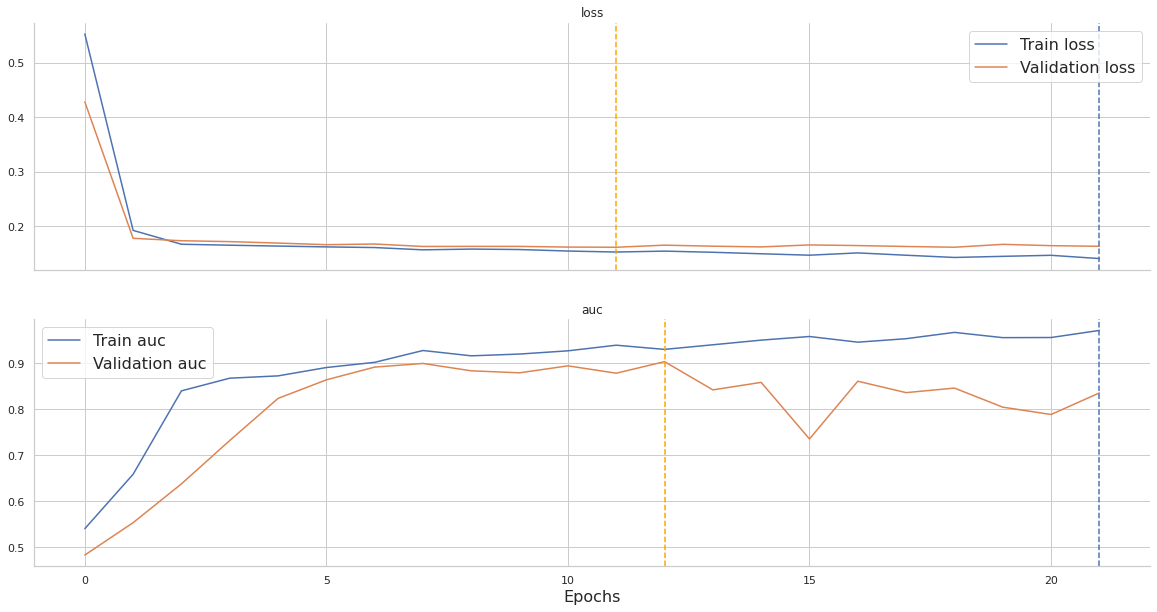

In [22]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

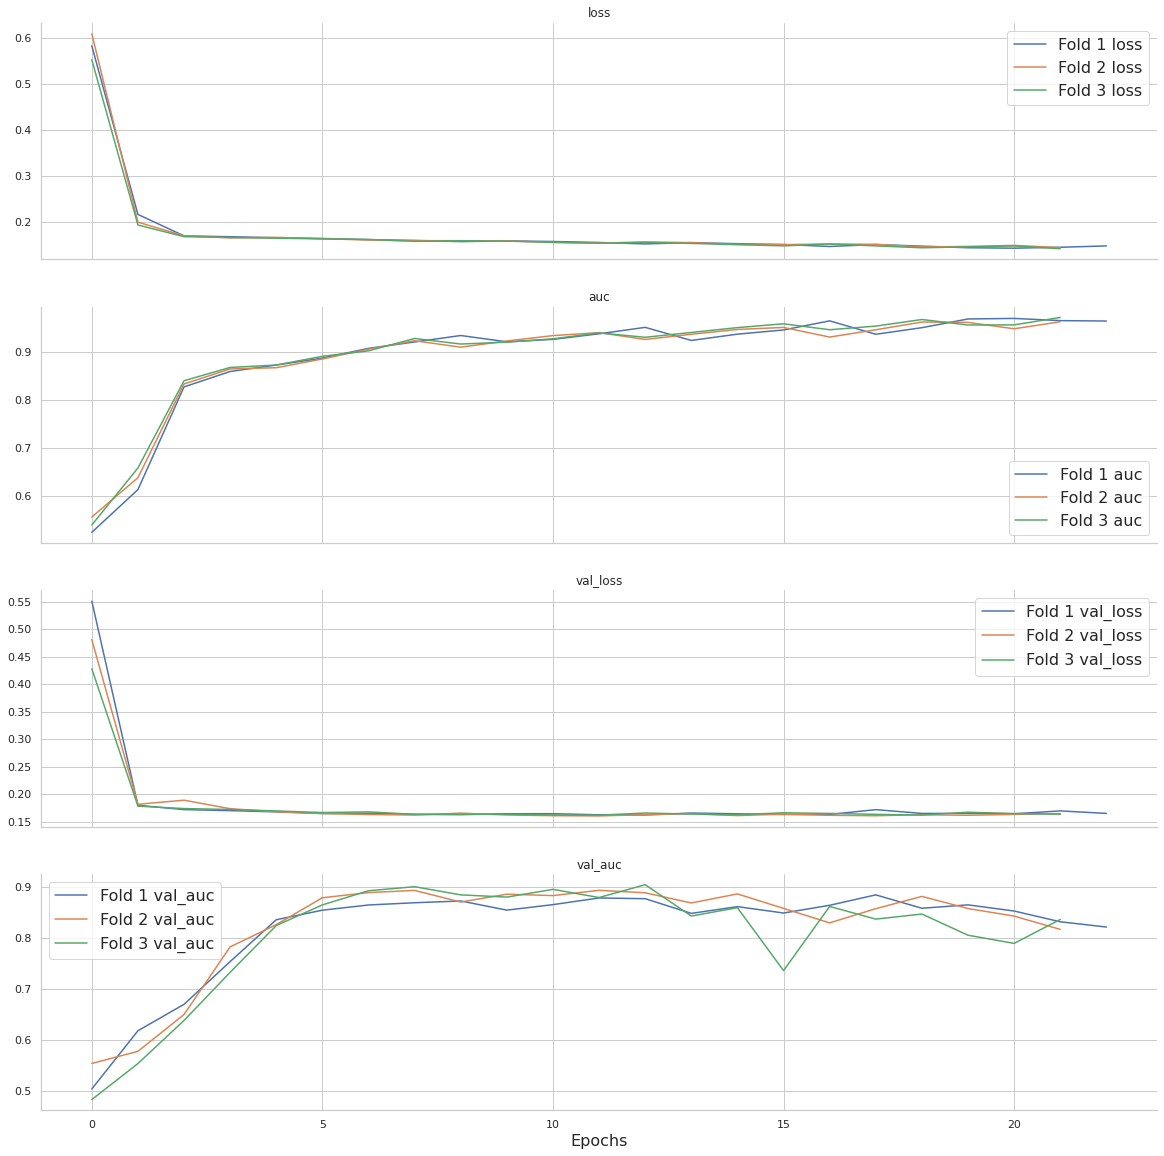

In [23]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [24]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.991259,0.837103,0.154156,0.990102,0.840282,0.989474,0.829054,0.994199,0.841972
Accuracy,0.994412,0.982121,0.012291,0.994123,0.982255,0.993869,0.982617,0.995244,0.981490
Precision,0.939015,0.471024,0.467991,0.974441,0.400000,0.923288,0.527778,0.919315,0.485294
Recall,0.732587,0.183290,0.549297,0.688488,0.085106,0.710970,0.172727,0.798301,0.292035
F1-score,0.821587,0.255089,0.566498,0.806878,0.140351,0.803337,0.260274,0.854545,0.364641
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


# Model evaluation by Subset

In [25]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.991259,0.837103,0.154156,0.990102,0.840282,0.989474,0.829054,0.994199,0.841972
male,0.992996,0.836431,0.156564,0.991473,0.866022,0.992715,0.800517,0.994798,0.842754
female,0.988766,0.837986,0.150779,0.987722,0.799708,0.985368,0.876330,0.993208,0.837921
head/neck,0.995266,0.779810,0.215456,0.994969,0.816279,0.992510,0.706432,0.998317,0.816718
upper extremity,0.990207,0.846138,0.144069,0.997494,0.873706,0.978136,0.796195,0.994992,0.868513
lower extremity,0.986400,0.799542,0.186859,0.979743,0.784517,0.988342,0.831897,0.991116,0.782211
torso,0.993331,0.866719,0.126612,0.992843,0.860183,0.993003,0.882127,0.994147,0.857848
0 <= age < 26,0.978745,0.786112,0.192633,0.980646,0.908042,0.976227,0.605568,0.979361,0.844724
26 <= age < 40,0.991216,0.827037,0.164179,0.984215,0.901931,0.993485,0.785714,0.995947,0.793465


# Model evaluation (best)

In [26]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.975377,0.883311,0.092066,0.978890,0.875113,0.971944,0.891041,0.975298,0.883781
Accuracy,0.987981,0.983274,0.004706,0.988689,0.982496,0.987552,0.983583,0.987701,0.983744
Precision,0.892841,0.653199,0.239643,0.882075,0.444444,0.879781,0.681818,0.916667,0.833333
Recall,0.362916,0.127527,0.235389,0.422122,0.113475,0.339662,0.136364,0.326964,0.132743
F1-score,0.514367,0.212357,0.302010,0.570992,0.180791,0.490107,0.227273,0.482003,0.229008
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.975377,0.883311,0.092066,0.978890,0.875113,0.971944,0.891041,0.975298,0.883781
male,0.976799,0.891563,0.085235,0.978919,0.897518,0.973918,0.884820,0.977559,0.892351
female,0.972687,0.865302,0.107384,0.978023,0.840213,0.968605,0.895841,0.971432,0.859854
head/neck,0.972389,0.843491,0.128898,0.977260,0.813140,0.974864,0.800304,0.965042,0.917028
upper extremity,0.971968,0.890898,0.081070,0.976457,0.869789,0.963065,0.893717,0.976382,0.909188
lower extremity,0.966974,0.832139,0.134835,0.972854,0.796940,0.963563,0.862498,0.964506,0.836978
torso,0.980816,0.919674,0.061142,0.982974,0.929761,0.977768,0.939699,0.981705,0.889562
0 <= age < 26,0.943629,0.866846,0.076783,0.940107,0.862587,0.939103,0.841067,0.951676,0.896882
26 <= age < 40,0.975241,0.844038,0.131203,0.973687,0.905572,0.968372,0.806673,0.983663,0.819867


# Confusion matrix

Fold: 1


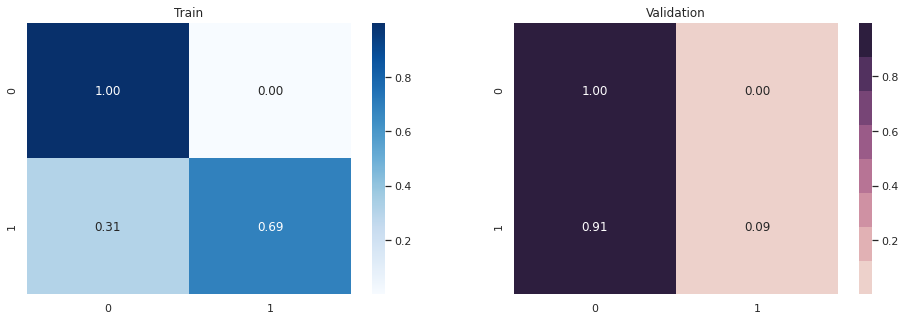

Fold: 2


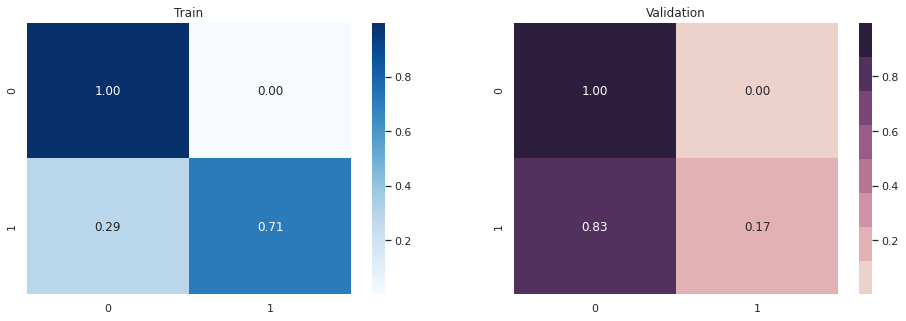

Fold: 3


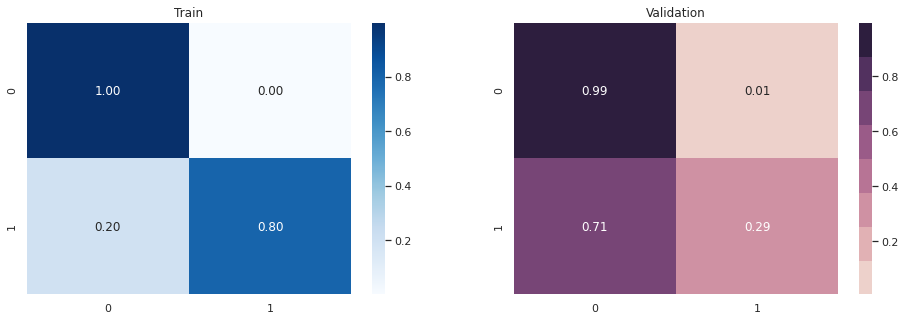

In [27]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [28]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.013392,0.024844,0.019924,0.022192
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.015417,0.026896,0.022893,0.027293
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.015386,0.025878,0.026919,0.024132
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.015103,0.025847,0.023358,0.026312
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.016874,0.027300,0.027940,0.029130
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.015639,0.026849,0.023979,0.027365
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.014945,0.022840,0.025038,0.026845
7,ISIC_0075663,female,35.0,torso,unknown,0,0.014861,0.023640,0.025058,0.025606
8,ISIC_0075914,male,30.0,torso,unknown,0,0.016222,0.029553,0.025728,0.025830
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.015453,0.026908,0.022620,0.027739


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.023497,0.026698,0.026451,0.064336
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.262340,0.062463,0.385396,0.863843
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.276654,0.484550,0.845302,0.053419
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.153968,0.027494,0.064099,0.678247
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.274139,0.029244,0.475108,0.866343
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.492163,0.851032,0.814431,0.795353
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.438689,0.870072,0.436431,0.886941
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.383981,0.130022,0.872264,0.917616
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.211307,0.045423,0.287423,0.723689
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.276289,0.869058,0.482828,0.029559


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.506439,0.834130,0.927639,0.770425
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.521078,0.932678,0.756870,0.915843
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.538705,0.850326,0.920596,0.922605
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.511327,0.803843,0.822685,0.930104
1654,ISIC_0599605,male,70.0,upper extremity,melanoma,1,0.508056,0.810190,0.892845,0.837246
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.526939,0.913482,0.827485,0.893729
2709,ISIC_0911264,male,65.0,lower extremity,melanoma,1,0.525636,0.866940,0.866538,0.894701
2856,ISIC_0953317,male,65.0,torso,melanoma,1,0.512752,0.829291,0.842484,0.891984
2886,ISIC_0961235,female,45.0,torso,melanoma,1,0.516033,0.839132,0.902880,0.838153
3571,ISIC_1177153,male,65.0,torso,melanoma,1,0.500893,0.905095,0.708484,0.890885


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 97
Train positive correct predictions: 97


# Make predictions (best)

In [29]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_3.h5


In [30]:
#@title
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/model_fold_3.h5
Running TTA


# Make predictions (last)

In [31]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_3.h5


In [32]:
#@title
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/43-efficientnetb0/last_model_fold_3.h5
Running TTA


# Visualize test predictions

In [33]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 34|10948
Test predictions (last) 66|10916
Test predictions (tta) 24|10958
Test predictions (last tta) 53|10929
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.025032,0.025913,0.024877,0.026027
1,ISIC_0052349,male,40.0,lower extremity,0.024982,0.023408,0.020986,0.023663
2,ISIC_0058510,female,55.0,torso,0.022563,0.025723,0.022577,0.025730
3,ISIC_0073313,female,50.0,torso,0.025998,0.027217,0.025483,0.026901
4,ISIC_0073502,female,45.0,lower extremity,0.047196,0.032496,0.046373,0.033899
5,ISIC_0074618,male,50.0,lower extremity,0.032951,0.028655,0.029819,0.029943
6,ISIC_0076801,male,45.0,upper extremity,0.020264,0.026462,0.020323,0.028041
7,ISIC_0077586,male,50.0,lower extremity,0.044440,0.027400,0.042020,0.027361
8,ISIC_0082004,female,45.0,torso,0.022927,0.024037,0.027404,0.027945
9,ISIC_0082785,male,65.0,lower extremity,0.023201,0.023267,0.023705,0.025182


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
403,ISIC_0481105,male,80.0,torso,0.636381,0.893453,0.579988,0.804583
1334,ISIC_1294368,female,35.0,torso,0.636424,0.727194,0.529913,0.785865
1408,ISIC_1364884,female,35.0,upper extremity,0.643794,0.814635,0.526251,0.769593
1485,ISIC_1429763,male,45.0,head/neck,0.582105,0.807681,0.410035,0.631181
1677,ISIC_1593714,female,50.0,lower extremity,0.704948,0.857920,0.636298,0.875297
1764,ISIC_1670692,male,50.0,torso,0.528479,0.748920,0.469143,0.728309
2293,ISIC_2170268,female,80.0,upper extremity,0.562653,0.599316,0.270868,0.252432
2739,ISIC_2560699,male,70.0,torso,0.690440,0.560580,0.706225,0.738583
2750,ISIC_2568903,male,85.0,upper extremity,0.638623,0.856326,0.426118,0.564136
3045,ISIC_2839742,male,70.0,upper extremity,0.713358,0.879538,0.705532,0.890600


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
403,ISIC_0481105,male,80.0,torso,0.636381,0.893453,0.579988,0.804583
552,ISIC_0606244,male,70.0,torso,0.484897,0.763073,0.250594,0.477098
764,ISIC_0775584,female,35.0,lower extremity,0.410112,0.556379,0.124586,0.215964
860,ISIC_0867509,female,80.0,torso,0.403041,0.524325,0.346379,0.457437
1156,ISIC_1114416,female,40.0,torso,0.211511,0.514059,0.210809,0.402248
1250,ISIC_1212424,male,55.0,torso,0.452934,0.519836,0.546832,0.672903
1307,ISIC_1269448,male,80.0,upper extremity,0.463707,0.580668,0.320877,0.615786
1334,ISIC_1294368,female,35.0,torso,0.636424,0.727194,0.529913,0.785865
1408,ISIC_1364884,female,35.0,upper extremity,0.643794,0.814635,0.526251,0.769593
1485,ISIC_1429763,male,45.0,head/neck,0.582105,0.807681,0.410035,0.631181


# Test set predictions

In [34]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.025032,0.025913,0.025473,0.024877,0.026027,0.025452
1,ISIC_0052349,0.024982,0.023408,0.024195,0.020986,0.023663,0.022324
2,ISIC_0058510,0.022563,0.025723,0.024143,0.022577,0.025730,0.024154
3,ISIC_0073313,0.025998,0.027217,0.026608,0.025483,0.026901,0.026192
4,ISIC_0073502,0.047196,0.032496,0.039846,0.046373,0.033899,0.040136
5,ISIC_0074618,0.032951,0.028655,0.030803,0.029819,0.029943,0.029881
6,ISIC_0076801,0.020264,0.026462,0.023363,0.020323,0.028041,0.024182
7,ISIC_0077586,0.044440,0.027400,0.035920,0.042020,0.027361,0.034691
8,ISIC_0082004,0.022927,0.024037,0.023482,0.027404,0.027945,0.027675
9,ISIC_0082785,0.023201,0.023267,0.023234,0.023705,0.025182,0.024443


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.041218,0.039957,0.040588,0.039794,0.040406,0.040100
std,0.053533,0.064307,0.056826,0.047419,0.059989,0.052015
min,0.015001,0.020074,0.019205,0.017176,0.021005,0.020281
25%,0.024027,0.025595,0.024975,0.024203,0.025879,0.025159
50%,0.027197,0.026964,0.027061,0.027191,0.027438,0.027389
75%,0.036267,0.029808,0.033160,0.035310,0.031088,0.033320
max,0.713358,0.893453,0.796448,0.706225,0.890600,0.798066
